In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
from scipy.special import expit
from functools import partial



import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [30]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def label_encoding(train, test=None, feat_to_encode=None):
    train = train.copy()
    if test is not None:
        test = test.copy()
    
    # Определяем признаки для кодирования
    if feat_to_encode is None:
        feat_to_encode = train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for feature in feat_to_encode:
        # Создаем словарь для маппинга
        le = LabelEncoder()
        train_encoded = le.fit_transform(train[feature].astype(str))
        
        # Создаем маппинг для быстрого преобразования
        label_mapping = {val: idx for idx, val in enumerate(le.classes_)}
        
        # Применяем к train
        train[feature] = train_encoded
        
        # Применяем к test если есть
        if test is not None:
            # Векторизованная операция вместо apply
            test[feature] = test[feature].astype(str).map(label_mapping).fillna(-1).astype(int)
    
    return train, test

In [31]:
import numpy as np
import lightgbm as lgb

# 1. Определяем кастомную функцию потерь
def custom_loss(y_true, y_pred):
    """
    y_true: array-like, истинные значения
    y_pred: array-like, предсказанные значения
    """
    # Пример: Huber loss - менее чувствительна к выбросам, чем MSE
    delta = 1.0  # параметр для Huber loss
    residual = y_true - y_pred
    is_small_error = np.abs(residual) <= delta
    squared_loss = 0.5 * residual**2
    linear_loss = delta * (np.abs(residual) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# 2. Определяем функции градиента и гессиана
def custom_loss_gradient(y_true, y_pred):
    delta = 1.0

    print(y_true)
    print(y_pred.get_label())

    residual = y_true - y_pred.get_label()
    gradient = np.where(np.abs(residual) <= delta, -residual, -delta * np.sign(residual))
    return gradient

def custom_loss_hessian(y_true, y_pred):
    delta = 1.0
    residual = y_true - y_pred.get_label()
    hessian = np.where(np.abs(residual) <= delta, 1.0, 0.0)
    return hessian

# 3. Регистрируем кастомные функции
def custom_objective(y_pred, y_true):
    """Функция, которую ожидает LightGBM"""
    grad = custom_loss_gradient(y_true, y_pred)
    hess = custom_loss_hessian(y_true, y_pred)
    return grad, hess

def custom_eval(y_true, y_pred):
    """Функция для оценки (необязательно)"""
    loss = custom_loss(y_true, y_pred)
    return 'custom_loss', np.mean(loss), False

In [32]:
def focal_loss_grad_hess(y_raw, tr, gamma=0):
    y_true = tr.get_label()
    y_prob = np.clip(expit(y_raw), 1e-15, 1 - 1e-15)
    pt = np.where(y_true, y_prob, 1 - y_prob)
    
    y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
    grad = y * (1 - pt) ** gamma * (gamma * pt * np.log(pt) + pt - 1)

    u = y * (1 - pt) ** gamma
    du = y * gamma * (1 - pt) ** (gamma - 1)
    v = gamma * pt * np.log(pt) + pt - 1
    dv = gamma * np.log(pt) + gamma + 1
    hess = (du * v + u * dv) * y * (pt * (1 - pt))
    return grad, hess

def focal_loss(predictions, tr, gamma=0, is_custom_objective=False):
    y_true = tr.get_label()
    y_prob = expit(predictions) if is_custom_objective else predictions
    y_prob = np.clip(y_prob, 1e-15, 1 - 1e-15)
    pt = np.where(y_true, y_prob, 1 - y_prob)
    return 'focal_loss', np.mean(- (1 - pt) ** gamma * np.log(pt)), False

In [ ]:
from sklearn.model_selection import train_test_split

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

features = list(train.drop('target', axis=1).columns)

cat_features = []

for feature in features:
    if 'cat' in feature:
        cat_features.append(feature)

for feat in cat_features:
    train[feat] = train[feat].astype('category')

lgb_df = lgb.Dataset(data=train[features], label=train.target, categorical_feature=cat_features)

gamma = 0
params = {
    'seed': 911,
    'nthread': 16,
    'verbose': -1,
    
    'eta': 0.1,
    'boost_from_average': False, # не работает на кастомных лоссах
    'is_unbalance': False, # не работает на кастомных лоссах
    'scale_pos_weight': 1, # не работает на кастомных лоссах
    
    'objective': partial(focal_loss_grad_hess, gamma=gamma),
    'metric': 'MAPE'
}

X_train, X_val, y_train, y_val = train_test_split(
    train[features], 
    train['target'], 
    test_size=0.3, 
    random_state=911
)

lgb_tr = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=cat_features, reference=lgb_tr)  # reference важно для категориальных фич

model_focal = lgb.train(
    train_set= lgb_tr,
    valid_sets= [lgb_val],
    valid_names= ['val'],
    num_boost_round= 140,
    callbacks= [lgb.log_evaluation(period=20)],
    params=params,
    feval=partial(focal_loss, is_custom_objective=True, gamma=gamma),
)

[20]	val's mape: 1	val's focal_loss: 0.692853
[40]	val's mape: 0.999999	val's focal_loss: 0.69256
[60]	val's mape: 0.999999	val's focal_loss: 0.692266
[80]	val's mape: 0.999998	val's focal_loss: 0.691973
[100]	val's mape: 0.999998	val's focal_loss: 0.69168
[120]	val's mape: 0.999997	val's focal_loss: 0.691387
[140]	val's mape: 0.999997	val's focal_loss: 0.691094


In [40]:
for feat in cat_features:
    test[feat] = test[feat].astype('category')

test['target'] = model_focal.predict(test[features])

test[['index', 'target']].to_csv('test.csv', index=False)

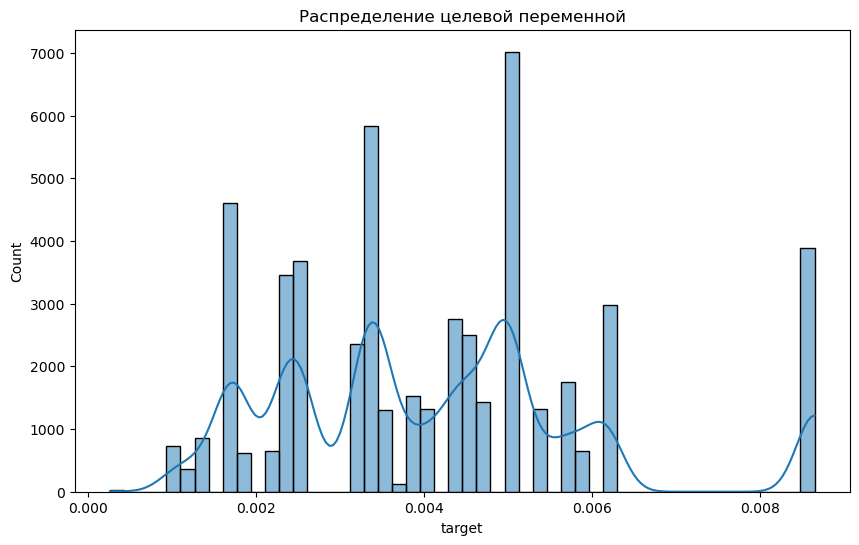

In [41]:
# Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=test, x='target', bins=50, kde=True)
plt.title('Распределение целевой переменной')
plt.show()

In [36]:
ы

NameError: name 'ы' is not defined

In [ ]:
def my_beeswarm(df: pd.DataFrame, features: list[str],
                cat_feature_threshold: float, shap_values: np.ndarray,
                top_k: int = 10, figsize: tuple[int, int] = (10, 6),
                dots: int = 1000) -> plt.Figure:
    """
    Улучшенная версия beeswarm plot для визуализации SHAP значений.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходные данные
    features : list[str]
        Список признаков
    cat_feature_threshold : float
        Порог для отображения категориальных значений (минимальная частота)
    shap_values : np.ndarray
        SHAP значения (N x F+1), последний столбец - константа
    top_k : int, optional
        Количество топовых признаков для отображения (по умолчанию 10)
    figsize : tuple[int, int], optional
        Размер фигуры (по умолчанию (10, 6))
    dots : int, optional
        Количество точек для отображения (по умолчанию 1000)

    Возвращает:
    -----------
    plt.Figure
        Объект matplotlib Figure с визуализацией
    """

    # 1. Предобработка SHAP значений
    shap_values = shap_values[:, :-1]
    df_shap = pd.DataFrame(shap_values, columns=features)

    # 2. Обработка категориальных признаков
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for cat in cat_cols:
        if cat not in features:
            continue

        value_counts = df[cat].value_counts(normalize=True)
        filtered_values = value_counts[value_counts >= cat_feature_threshold].index

        new_cols = {
            f"{cat} == {value}": (df[cat] == value).astype(int)
            for value in filtered_values
        }

        # Создаем новер бинарные признаки
        new_df = pd.DataFrame(new_cols)
        df = pd.concat([df, new_df], axis=1)

        # Для SHAP значений - копируем оригинальные значения только для соответствующих категорий
        for value in filtered_values:
            mask = (df[cat] == value)
            df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)

        df.drop(columns=[cat], inplace=True)
        df_shap.drop(columns=[cat], inplace=True)

    # 3. Выбор top_k признаков
    mean_shap_value = df_shap.abs().mean().sort_values(ascending=False)
    top_features = mean_shap_value.head(top_k).index.tolist()

    # 4. Сэмплирование
    if len(df) > dots:
        index_sample = np.random.choice(df.index, size=dots, replace=False)
        df_sampled = df.loc[index_sample]
        df_shap_sampled = df_shap.loc[index_sample]
    else:
        df_sampled = df.copy()
        df_shap_sampled = df_shap.copy()

    fig, ax = plt.subplots(figsize=figsize)

    # 5. Построение графика для каждого признака
    for i, feature in enumerate(top_features):
        # Подготовка данных для текущего признака
        shap_data = df_shap_sampled[feature]
        feature_data = df_sampled[feature] if feature in df_sampled else None

        # Разделение на пропущенные и непропущенные значения
        if feature_data is not None:
            is_missing = feature_data.isna()
            missing_shap = shap_data[is_missing]
            non_missing_shap = shap_data[~is_missing]
            non_missing_values = feature_data[~is_missing]
        else:
            # Для dummy-переменных нет пропущенных значений
            is_missing = pd.Series(False, index=shap_data.index)
            non_missing_shap = shap_data
            non_missing_values = None

        # Визуализация непропущенных значений
        if len(non_missing_shap) > 0:
            if " == " in feature:  # Категориальный признак
                sns.stripplot(
                    x=non_missing_shap.values,
                    y=[feature] * len(non_missing_shap),
                    ax=ax,
                    color='purple',
                    alpha=0.7,
                    jitter=0.3,
                    size=4,
                    linewidth=0.5
                )
            else:  # Числовой признак
                # Подготовка данных для цветового градиента
                vals = non_missing_values
                if vals.nunique() > 1:
                    # Обрезка выбросов для цветовой шкалы
                    vmin, vmax = vals.quantile([0.01, 0.99])
                    clipped_vals = vals.clip(vmin, vmax)

                    # Создаем DataFrame для stripplot, но можно было и просто записать все в параметры напрямую
                    plot_df = pd.DataFrame({
                        'shap': non_missing_shap.values,
                        'feature': [feature] * len(non_missing_shap),
                        'value': clipped_vals
                    })

                    # Рисуем с цветовым градиентом
                    sns.stripplot(
                        x='shap',
                        y='feature',
                        hue='value',
                        data=plot_df,
                        ax=ax,
                        palette='coolwarm',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5,
                        hue_norm=(vmin, vmax)
                    )

                    # Убираем легенду, потому что она будет дублировать colorbar
                    ax.get_legend().remove()
                else:
                    # Если все значения одинаковые - синий цвет
                    sns.stripplot(
                        x=non_missing_shap.values,
                        y=[feature] * len(non_missing_shap),
                        ax=ax,
                        color='blue',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5
                    )

        # Визуализация пропущенных значений
        if len(missing_shap) > 0:
            ax.plot(
                missing_shap.values,
                [feature]*len(missing_shap),
                'o',
                color='black',
                alpha=0.9,
                markersize=4,
                markeredgecolor='black',
                markeredgewidth=1,
                zorder = 10
            )

    # Добавление вертикальной линии на 0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel('SHAP value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Custom Beeswarm Plot of SHAP Values', fontsize=14)

    # Добавление colorbar для числовых признаков
    if any(" == " not in f for f in top_features):
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Feature value (normalized)', rotation=270, labelpad=15)

    plt.tight_layout()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\2265522689.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\2265522689.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\2265522689.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

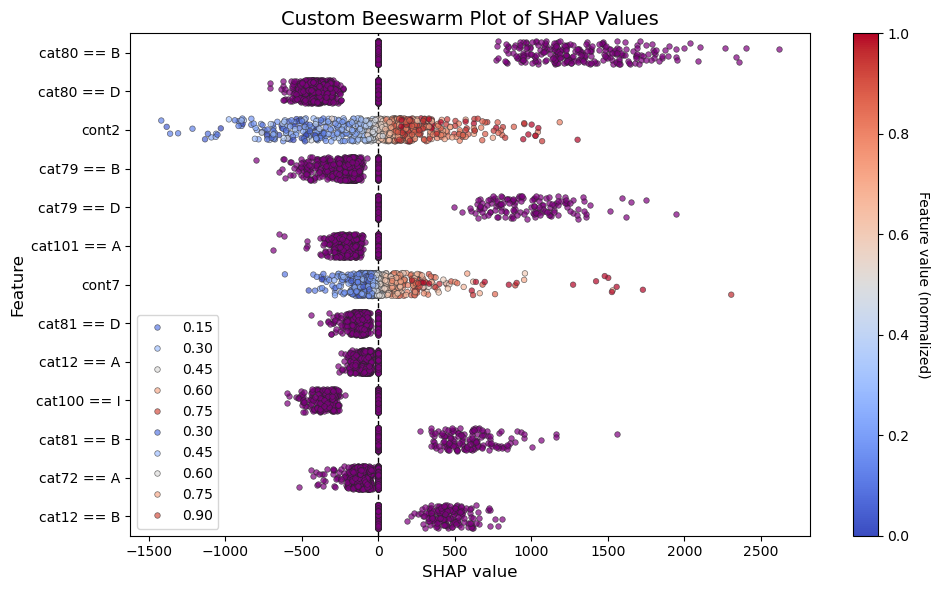

In [ ]:
my_beeswarm(train, features, cat_feature_threshold=0.001, shap_values=model.predict(train[features], pred_contrib=True), top_k=13, figsize=(10, 6), dots=1000)